# IPv6 Header Enconder

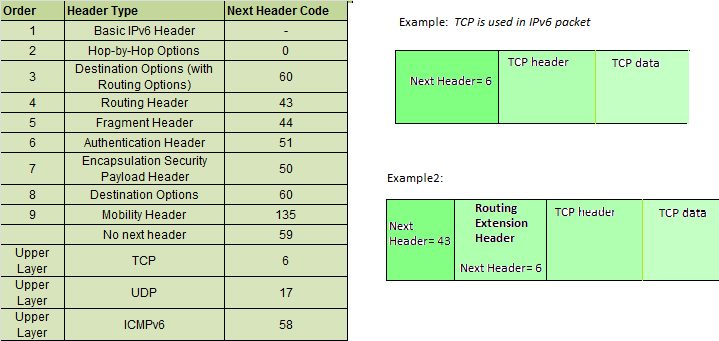

<b> Change the interface name to get the ip of your net interface </b>

In [34]:
#Imports 
import scapy.all as scpy
import netifaces as ni
import socket
import random
#import os
#import getpass

#Get computer information
interface_name = 'eth0'
#os.system("sudo add "+interface_name+" fe80::2cdc:3f09:4d85:d058")
#ip = ni.ifaddresses('enp0s17')[ni.AF_INET6][0]["addr"]
ip = "::1"

*Helper functions*

Make the encoding and decoding by ourselves

In [2]:
def to_ascii(str):
    return [ord(c) for c in str]

def from_ascii_to_bin(s):
    return ''.join(bin(x)[2:].zfill(8) for x in s.encode('ascii'))

def from_ascii_to_hex(s):
    res = ""
    for c in s:
        res += str(ord(c))
    return res

def from_ascii_toIP6(s):
    res = ""
    i = 1;
    l = len(s)
    for c in s:
        res += str(ord(c))
        if(i % 2 == 0 and l!=i):
            res += ":"
        i+=1;
    return res

def from_bin_to_ascii(s):
    n = int(s, 2)
    return n.to_bytes((n.bit_length() + 7) // 8, 'big').decode()

def from_int_to_bin(i):
    return "{0:b}".format(i)

test = "aaaa"
res = [97,97,97,97]

def to_char(num):
    return "".join([chr(n) for n in num])

to_ascii(test) == res and to_char(res) == test


print(from_bin_to_ascii("01000010") == "B")

True


### USING THE STANDARD IPV6 HEADER
#### Basic IPv6 header

In [3]:
scpy.ls(scpy.IPv6)

version    : BitField  (4 bits)                  = (6)
tc         : BitField  (8 bits)                  = (0)
fl         : BitField  (20 bits)                 = (0)
plen       : ShortField                          = (None)
nh         : ByteEnumField                       = (59)
hlim       : ByteField                           = (64)
src        : SourceIP6Field                      = (None)
dst        : DestIP6Field                        = (None)


We could use from the base header of the IPv6 packet:
    - Traffic Field: 8 bits
    - Flow Field:   20 bits
    -----------------------
      Total:        38 bits

In [4]:
#Sending two ascii characters using the tc and fl field
def encodeTcField(a):
    return ord(a)

def encodeFlowField(b,c):
    s = b + c
    return int(from_ascii_to_bin(s),2)

def decodeFlowField(x):
    res = "{0:b}".format(x)
    return chr(int(res[:7],2)) + chr(int(res[-8:], 2)) 

def decodeTcField(x):
    return chr(x)

#b = encodeFlowField('b','b')

def sendRecvThreeChars(a,b,c, show=False):
    snd = scpy.IPv6(dst=ip,src=ip)
    snd.tc = encodeTcField(a)
    snd.fl = encodeFlowField(b,c)
    r = scpy.sr1(snd)
    if show:
        snd.show()
        r.show()
    return decodeTcField(r.tc) + decodeFlowField(r.fl);

def sendRecvTwo(a,b, show=False):
    snd = scpy.IPv6(dst=ip,src=ip)
    snd.tc = encodeTcField(a)
    snd.fl = encondeTcField(b)
    r = scpy.sr1(snd)
    if show:
        snd.show()
        r.show()
    return decodeTcField(r.tc) + decodeTcField(r.fl);

def sendRecvOne(a,show = False):
    snd = scpy.IPv6(dst=ip,src=ip)
    snd.tc = encodeTcField(a)
    r = scpy.sr1(snd)
    if show:
        snd.show()
        r.show()
    return decodeTcField(r.tc);

#bb = [98,98]

print("Received message " + sendRecvThreeChars('a','b','c')) 

Begin emission:
Finished sending 1 packets.

Received 1 packets, got 1 answers, remaining 0 packets
*Received message abc


*TODO* Transmit more data using the last bits that we discard 20-16 = 4 (half a char!!)
*TODO* Implement encryption

In [5]:
#Get the remainder
def getBound(x):
    return x - (x % 3)

data = "tesT"


def sendRecvString(data,show=False):
    l = len(data)
    bound = getBound(l)
    res = ""
    if(l >= 3):
        for x in range(0, bound, 3):
            res = res + sendRecvThreeChars(data[x],data[x+1],data[x+2],show)
    
    if(bound == l-1):
        res = res + sendRecvOne(data[l-1],show)
    elif (bound == l-2):
        res = res + sendRecvTwo(data[l-2],data[l-1],show)
    return res;
    
print("Response " + sendRecvString(data,True))
print(data == sendRecvString(data),sendRecvString("fkjsalk") == "fkjsalk", 
      "lkfjasklfjas" == sendRecvString("lkfjasklfjas") )

Begin emission:
Finished sending 1 packets.

Received 1 packets, got 1 answers, remaining 0 packets
*###[ IPv6 ]### 
  version   = 6
  tc        = 116
  fl        = 25971
  plen      = None
  nh        = No Next Header
  hlim      = 64
  src       = ::1
  dst       = ::1

###[ IPv6 ]### 
  version   = 6
  tc        = 116
  fl        = 25971
  plen      = 0
  nh        = No Next Header
  hlim      = 64
  src       = ::1
  dst       = ::1

Begin emission:
Finished sending 1 packets.

Received 1 packets, got 1 answers, remaining 0 packets
*###[ IPv6 ]### 
  version   = 6
  tc        = 84
  fl        = 0
  plen      = None
  nh        = No Next Header
  hlim      = 64
  src       = ::1
  dst       = ::1

###[ IPv6 ]### 
  version   = 6
  tc        = 84
  fl        = 0
  plen      = 0
  nh        = No Next Header
  hlim      = 64
  src       = ::1
  dst       = ::1

Response tesT
Begin emission:
Finished sending 1 packets.
*
Received 1 packets, got 1 answers, remaining 0 packets
Begin emiss

### Hop By Hop
#### We are gonna use the Hop by Hop Option to enconde the information

In [8]:
scpy.ls(scpy.IPv6ExtHdrHopByHop)

nh         : ByteEnumField                       = (59)
len        : FieldLenField                       = (None)
autopad    : _PhantomAutoPadField                = (1)
options    : _OptionsField                       = ([])


In [151]:
base = scpy.IPv6()
base.dst = ip
base.src = ip
extension = scpy.IPv6ExtHdrHopByHop()
jumbo = scpy.Jumbo()
jumbo.jumboplen = 2 ** 31
extension.options = jumbo
packet = base/extension
#packet.show2()
r = scpy.sr1(packet)
r.show()

Begin emission:
Finished sending 1 packets.

Received 1 packets, got 1 answers, remaining 0 packets
*###[ IPv6 ]### 
  version   = 6
  tc        = 0
  fl        = 0
  plen      = 8
  nh        = Hop-by-Hop Option Header
  hlim      = 64
  src       = ::1
  dst       = ::1
###[ IPv6 Extension Header - Hop-by-Hop Options Header ]### 
     nh        = No Next Header
     len       = 0
     autopad   = On
     \options   \
      |###[ Jumbo Payload ]### 
      |  otype     = Jumbo Payload [11: discard+ICMP not mcast, 0: Don't change en-route]
      |  optlen    = 4
      |  jumboplen = 2147483648



<b> We can encode till 2³¹ number therefore we can encode 32-bit -> 4 ascii characters

In [12]:
data = "This is sent by an IPv6 header"

def addPadding(data, n):
    l = n if len(data) % n == 0 else len(data) % n
    for i in range(0,n - l):
        data += " "
    return data

def encodeWord(data):
    return int(from_ascii_to_bin(data),2)

def decodeWord(data):
    return from_bin_to_ascii("{0:b}".format(data))


def sendPacketHopByHop(data, show=False):
    base = scpy.IPv6()
    base.dst = ip
    base.src = ip
    extension = scpy.IPv6ExtHdrHopByHop()
    jumbo = scpy.Jumbo()
    r = []
    data = addPadding(data,4)
    for i in range(0, len(data), 4):
        jumbo.jumboplen = encodeWord(data[i:i+4])
        extension.options = jumbo
        packet = base/extension
        if(show):
            packet.show2()
        r.append(scpy.sr1(packet))
    return r;

def receivePacket(res, show=False):
    if(show):
        r.show2();
    data = []
    for r in res:
        jum = r[0].options[0]
        data.append(decodeWord(jum.jumboplen))
    return data


#TEST IT

print(decodeWord(encodeWord(data)) == data)

res = sendPacketHopByHop(data)
receive = receivePacket(res)

for r in receive:
    print("Received: " + r)


True
Begin emission:
Finished sending 1 packets.
*
Received 1 packets, got 1 answers, remaining 0 packets
Begin emission:
Finished sending 1 packets.
*
Received 1 packets, got 1 answers, remaining 0 packets
Begin emission:
Finished sending 1 packets.
*
Received 1 packets, got 1 answers, remaining 0 packets
Begin emission:
Finished sending 1 packets.

Received 1 packets, got 1 answers, remaining 0 packets
*Begin emission:
Finished sending 1 packets.
*
Received 1 packets, got 1 answers, remaining 0 packets
Begin emission:
Finished sending 1 packets.
*
Received 1 packets, got 1 answers, remaining 0 packets
Begin emission:
Finished sending 1 packets.
*
Received 1 packets, got 1 answers, remaining 0 packets
Begin emission:
Finished sending 1 packets.

Received 1 packets, got 1 answers, remaining 0 packets
*Received: This
Received:  is 
Received: sent
Received:  by 
Received: an I
Received: Pv6 
Received: head
Received: er  


<b> Destination Unreachable Header </b>

In [393]:
scpy.ls(scpy.IPv6ExtHdrDestOpt)

nh         : ByteEnumField                       = (59)
len        : FieldLenField                       = (None)
autopad    : _PhantomAutoPadField                = (1)
options    : _OptionsField                       = ([])


_We can use the unsed field to transmit our data_

In [394]:
def sendPacketDestOpt(data,show=False):
    base = scpy.IPv6()
    base.dst = ip
    base.src = ip
    extension = scpy.IPv6ExtHdrDestOpt() #only this line changed we could have created a unified function
    jumbo = scpy.Jumbo()
    r = []
    data = addPadding(data,4)
    for i in range(0, len(data), 4):
        jumbo.jumboplen = encodeWord(data[i:i+4])
        extension.options = jumbo
        packet = base/extension
        if(show):
            packet.show2()
        r.append(scpy.sr1(packet))
    return r;

#TEST IT -- SAME AS PREVOIUS

res = sendPacketDestOpt(data) #Changed
receive = receivePacket(res)

for r in receive:
    print("Received: " + r)


Begin emission:
Finished sending 1 packets.
*
Received 1 packets, got 1 answers, remaining 0 packets
Begin emission:
Finished sending 1 packets.
*
Received 1 packets, got 1 answers, remaining 0 packets
Begin emission:
Finished sending 1 packets.
*
Received 1 packets, got 1 answers, remaining 0 packets
Begin emission:
Finished sending 1 packets.

Received 1 packets, got 1 answers, remaining 0 packets
*Begin emission:
Finished sending 1 packets.

Received 1 packets, got 1 answers, remaining 0 packets
*Begin emission:
Finished sending 1 packets.

Received 1 packets, got 1 answers, remaining 0 packets
*Begin emission:
Finished sending 1 packets.
*
Received 1 packets, got 1 answers, remaining 0 packets
Begin emission:
Finished sending 1 packets.
*
Received 1 packets, got 1 answers, remaining 0 packets
Received: This
Received:  is 
Received: sent
Received:  by 
Received: an I
Received: Pv6 
Received: head
Received: er  


### Routing Option

#### We could use the addresses field since it's deprecated

In [265]:
scpy.ls(scpy.IPv6ExtHdrRouting)

nh         : ByteEnumField                       = (59)
len        : FieldLenField                       = (None)
type       : ByteField                           = (0)
segleft    : ByteField                           = (None)
reserved   : BitField  (32 bits)                 = (0)
addresses  : IP6ListField                        = ([])


_Helper functions_

We have 32 bit net addresses -> we can encode 16 characters in our IPv6 net address

In [ ]:
dataR = "1234567890123456"
#print(from_ascii_toIP6(dataR))

def chopString16(data):
    l = []
    for i in range(0, len(data), 16):
        l.append(data[i:i+16])
    return l

def sendPacketRoutingOpt(data,show=False):
    base = scpy.IPv6()
    base.dst = ip
    base.src = ip
    data = addPadding(data,16) 
    chop = chopString16(data)
    payload = []
    for c in chop:
        payload.append(from_ascii_toIP6(c))
    print(payload)
    extension = scpy.IPv6ExtHdrRouting() #only this line changed we could have created a unified function
    extension.addresses = ["fe80::2cdc:3f09:4d85:d058"]
    packet = base/extension
    if(show):
            packet.show2()
    r = scpy.sr1(packet)
    return r;

r = sendPacketRoutingOpt(dataR)

r.show()
###TODO decoder
    

In [21]:
base = scpy.IPv6()
base.dst = "fe80::2cdc:3f09:4d85:d058"
base.src = ip
extension = scpy.IPv6ExtHdrRouting(addresses=["fe80::2cdc:3f09:4d85:d058"])
packet=base/extension
r = scpy.sr1(packet)
#r.show()

Begin emission:
Finished sending 1 packets.

Received 0 packets, got 0 answers, remaining 1 packets


#### Fragment Extension

In [24]:
scpy.ls(scpy.IPv6ExtHdrFragment())

nh         : ByteEnumField                       = 59              (59)
res1       : BitField  (8 bits)                  = 0               (0)
offset     : BitField  (13 bits)                 = 0               (0)
res2       : BitField  (2 bits)                  = 0               (0)
m          : BitField  (1 bit)                   = 0               (0)
id         : IntField                            = None            (None)


In [32]:
char = 'c'
base = scpy.IPv6()
base.src = ip
base.dst = ip
extension = scpy.IPv6ExtHdrFragment(res1=ord(char))
packet = base/extension
packet.show()
r = scpy.sr1(packet)

###[ IPv6 ]### 
  version   = 6
  tc        = 0
  fl        = 0
  plen      = None
  nh        = Fragment Header
  hlim      = 64
  src       = ::1
  dst       = ::1
###[ IPv6 Extension Header - Fragmentation header ]### 
     nh        = No Next Header
     res1      = 99
     offset    = 0
     res2      = 0
     m         = 0
     id        = None

Begin emission:
Finished sending 1 packets.
.........................................................................
Received 75 packets, got 0 answers, remaining 1 packets
..

#### ICMPv6EchoRequest

In [33]:
scpy.ls(scpy.ICMPv6EchoRequest())

type       : ByteEnumField                       = 128             (128)
code       : ByteField                           = 0               (0)
cksum      : XShortField                         = None            (None)
id         : XShortField                         = 0               (0)
seq        : XShortField                         = 0               (0)
data       : StrField                            = b''             (b'')


In [35]:
data = "x" * 1024
def sendString(data,show=False):
    base = scpy.IPv6()
    base.src = ip
    base.dst = ip
    extension = scpy.ICMPv6EchoRequest(data=data)
    packet = base/extension
    if(show):
        packet.show()
    r = scpy.sr1(packet)
    return r;

print(sendString(data).data)

Begin emission:
Finished sending 1 packets.

Received 2 packets, got 1 answers, remaining 0 packets
.*b'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

## Implementation of RSA comunication

**Implementation got from** www.github.com/swhiteh4t

In [24]:
import random,sys #random for random bits generator
import sympy as sp #sympy for some arithmetic computations 

ModuleNotFoundError: No module named 'sympy'

#### Helper funcitons

In [25]:
#Random k-bit number generator
def gennum(size,even=None):
    li=[random.choice([0,1]) for k in range(0,size-2)]
    if even=='even':
        li.append(0)
    elif even=='odd':
        li.append(1)
    else:
        li.append(random.choice([0,1]))
    num=li[0]
    for el in li[1:]:
        num<<=1
        num^=el
    return num

#Primality test
def GCD(a,b):
    while b:   
        a, b = b, a % b
    return abs(a)

def ExtendedGCD(a,b):
    r,r1=a,b
    s,s1=1,0 #s*a+t*b == a
    t,t1=0,1 #s1*a+t1*b == b
    while not(r1==0):
        q,r2=r//r1,r % r1
        r,s,t,r1,s1,t1=r1,s1,t1,r2,s-s1*q,t-t1*q
    d=r
    return d,s,t #s*a+t*b=d, d=GCD(a,b)

def IsComposite(a,n):
    d=GCD(a,n)
    if (d==1):
        a0=pow(a,n-1,n)
        if (a0 == 1):
            return False #"Not conclusive"
        else:
            return True
    else:
        return True
    
def IsCompositeTest(x,N):
    for _ in range(0,N):
        a=random.randrange(2,x-1)
        d=GCD(a,x)
        if d!=1:
            return True
        elif IsComposite(a,x):
            return True
    return False


#Pseudo-prime number generator
def GenPseudoPrime(N,size):
    num=gennum(size,'odd')
    while IsCompositeTest(num,size):
        num=gennum(size,'odd')
    return num



### Private and Public Key Generation

In [26]:
def GenTwoPrimes(size,N):
    while True:
        p=GenPseudoPrime(N,size)
        q=GenPseudoPrime(N,size)
        if p!=q:
            return p,q

def ProdModulus(size,N):
    p,q=GenTwoPrimes(size,N)
    n=p*q
    phin=(p-1)*(q-1)
    return n,phin

Compute $n=pq$ and $\phi(n)=(p-1)*(q-1)$

In [27]:
def ProdModulus(size,N):
    p,q=GenTwoPrimes(size,N)
    n=p*q
    phin=(p-1)*(q-1)
    return n,phin

def RandomE(phin):
    size=phin.bit_length()
    sizen=random.randrange(2,size)
    while True:
        num=gennum(sizen)
        if GCD(num,phin)==1 and num>1:
            return num
        
def ComputeD(e,phi):
    _,inv,_=ExtendedGCD(e,phi)
    return inv%phi

In [28]:
def PrivatePublicKeyRSA(size,N=200):
    n,phin=ProdModulus(size,N)
    e=RandomE(phin)
    d=ComputeD(e,phin)
    return d,(n,e)

In [48]:
AlicePriv,AlicePub=PrivatePublicKeyRSA(20)

In [49]:
def EncryptRSA(pub,m):
    n,e=pub
    c=pow(m,e,n) #fast modular exponentiation
    return c

In [50]:
def DecryptRSA(priv,pub,c):
    d=priv
    n,_=pub
    m=pow(c,d,n)
    return m



In [65]:
m=123456789
r = sendString(str(AlicePub))
pk = r.data

Begin emission:
Finished sending 1 packets.

Received 2 packets, got 1 answers, remaining 0 packets
.*

In [69]:
print(str(AlicePub) == pk.decode("utf-8"))
#Get the received pk and cipher the message m
aliceP = pk.decode("utf-8").replace("(","").replace(")","").split(",")
PK = (int(aliceP[0]),int(aliceP[1]))
r = sendString(str(EncryptRSA(PK,m)))
print(r.data)
DecryptRSA(AlicePriv,AlicePub,int(r.data)) == m

True
Begin emission:
Finished sending 1 packets.
.*
Received 2 packets, got 1 answers, remaining 0 packets
b'46930515906'


True